# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

2. I need to edit the levels of the training data so that anything where the signal is greater than 1 (due to high noise), should be normalised to 1

3. I may need to connect the features as images next to eachother, instead of channels in an input as the channels are cross effecting eachother in a negative way (where audio shoule be let through in one channel but bloced in one it is getting confused or assuming a relationship between channels when there is none)

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. maybe change how different samplerate images are concatenated
5. stop using cosine anealing as a straight learning rate is better

In [2]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout main")
    os.system("git pull origin main")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin main")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [4]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [5]:
from audioautoencoder.models.UNetRes12 import *
from audioautoencoder.models.UNetConv4 import *

## Test Model

In [6]:
BATCH_SIZE = 1
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 4, 1025 // 4, 175))
      model = UNetRes12(in_channels=4, out_channels=4)
      #model = UNetConv4(in_channels=4, out_channels=4)
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 256, 175])


In [7]:
!pip install torchinfo

In [8]:
from torchinfo import summary

# For example, if the input size is (batch_size=2, channels=9, height=256, width=256):
summary(model, input_size=(2, 4, 1025 // 4, 175))


Layer (type:depth-idx)                   Output Shape              Param #
UNetRes12                                [2, 4, 256, 175]          --
├─Sequential: 1-1                        [2, 32, 128, 88]          --
│    └─Conv2d: 2-1                       [2, 32, 128, 88]          1,184
│    └─GroupNorm: 2-2                    [2, 32, 128, 88]          64
│    └─LeakyReLU: 2-3                    [2, 32, 128, 88]          --
│    └─Conv2d: 2-4                       [2, 32, 128, 88]          9,248
│    └─GroupNorm: 2-5                    [2, 32, 128, 88]          64
│    └─LeakyReLU: 2-6                    [2, 32, 128, 88]          --
├─ResLayer: 1-2                          [2, 64, 64, 44]           --
│    └─ResBlock: 2-7                     [2, 32, 128, 88]          --
│    │    └─GroupNorm: 3-1               [2, 32, 128, 88]          64
│    │    └─ReLU: 3-2                    [2, 32, 128, 88]          --
│    │    └─Conv2d: 3-3                  [2, 32, 128, 88]          9,248
│    │

## Define Params

In [9]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.serialization.add_safe_globals([UNetRes12])
model = UNetRes12(in_channels=4, out_channels=4).to(device)


print(device)

cuda


In [10]:
i = 0
train = True
LOAD_DATA = True
load_model = True

# --------------- Main Execution parameters ---------------
model_name = 'UNetRes12'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = 'remapped-signal-level' # sep

# parameters
learning_rates = [1e-4] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 4
num_workers = 1

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512*2)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.0001
SNRdB: [-10, 10]


In [11]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [12]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [13]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [14]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)
      combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb, timeout=40)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_no_features(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size,
          num_workers=num_workers
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Created new file: /content/SNRdB_-10-10/train/combined_000.h5


Processing:   0%|          | 0/204 [00:00<?, ?it/s]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   0%|          | 1/204 [00:33<1:54:16, 33.77s/it, samples=500, size=0.668 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   1%|          | 2/204 [01:12<2:02:39, 36.43s/it, samples=1000, size=1.336 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   1%|▏         | 3/204 [02:29<3:04:58, 55.21s/it, samples=1500, size=2.005 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   2%|▏         | 4/204 [03:06<2:39:39, 47.90s/it, samples=2000, size=2.673 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   2%|▏         | 5/204 [03:41<2:23:43, 43.33s/it, samples=2500, size=3.341 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   3%|▎         | 6/204 [04:20<2:17:31, 41.67s/it, samples=2999, size=4.008 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   3%|▎         | 7/204 [04:59<2:14:55, 41.09s/it, samples=3498, size=4.675 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   4%|▍         | 8/204 [05:40<2:13:19, 40.81s/it, samples=3998, size=5.343 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   4%|▍         | 9/204 [06:17<2:08:43, 39.61s/it, samples=4498, size=6.011 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   5%|▍         | 10/204 [06:52<2:03:45, 38.27s/it, samples=4997, size=6.678 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   5%|▌         | 11/204 [07:30<2:02:55, 38.21s/it, samples=5497, size=7.347 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   6%|▌         | 12/204 [08:10<2:03:43, 38.67s/it, samples=5997, size=8.015 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   6%|▋         | 13/204 [08:46<2:00:52, 37.97s/it, samples=6496, size=8.682 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   7%|▋         | 14/204 [09:28<2:03:44, 39.08s/it, samples=6996, size=9.35 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   7%|▋         | 15/204 [10:06<2:02:51, 39.00s/it, samples=7496, size=10.018 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   8%|▊         | 16/204 [10:50<2:06:09, 40.26s/it, samples=7996, size=10.686 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   8%|▊         | 17/204 [11:32<2:07:37, 40.95s/it, samples=8494, size=11.352 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   9%|▉         | 18/204 [12:13<2:06:41, 40.87s/it, samples=8993, size=12.019 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:   9%|▉         | 19/204 [12:54<2:06:23, 40.99s/it, samples=9493, size=12.687 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  10%|▉         | 20/204 [13:34<2:04:39, 40.65s/it, samples=9991, size=13.353 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  10%|█         | 21/204 [14:15<2:03:51, 40.61s/it, samples=10491, size=14.021 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  11%|█         | 22/204 [14:51<1:59:29, 39.39s/it, samples=10991, size=14.689 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  11%|█▏        | 23/204 [15:27<1:55:58, 38.44s/it, samples=11490, size=15.356 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  12%|█▏        | 24/204 [16:07<1:56:03, 38.69s/it, samples=11990, size=16.024 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  12%|█▏        | 25/204 [16:41<1:51:13, 37.28s/it, samples=12490, size=16.692 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  13%|█▎        | 26/204 [17:20<1:52:48, 38.02s/it, samples=12990, size=17.361 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  13%|█▎        | 27/204 [18:01<1:54:10, 38.70s/it, samples=13490, size=18.029 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  14%|█▎        | 28/204 [18:40<1:54:25, 39.01s/it, samples=13988, size=18.694 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  14%|█▍        | 29/204 [19:56<2:25:26, 49.87s/it, samples=14486, size=19.36 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  15%|█▍        | 30/204 [20:39<2:19:08, 47.98s/it, samples=14986, size=20.028 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  15%|█▌        | 31/204 [21:20<2:12:03, 45.80s/it, samples=15486, size=20.697 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  16%|█▌        | 32/204 [21:58<2:04:52, 43.56s/it, samples=15986, size=21.365 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  16%|█▌        | 33/204 [22:39<2:01:41, 42.70s/it, samples=16486, size=22.033 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  17%|█▋        | 34/204 [23:17<1:57:23, 41.43s/it, samples=16985, size=22.7 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  17%|█▋        | 35/204 [23:58<1:56:00, 41.18s/it, samples=17485, size=23.368 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  18%|█▊        | 36/204 [24:39<1:55:01, 41.08s/it, samples=17983, size=24.034 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  18%|█▊        | 37/204 [25:19<1:53:20, 40.72s/it, samples=18482, size=24.701 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  19%|█▊        | 38/204 [25:57<1:51:02, 40.14s/it, samples=18982, size=25.369 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  19%|█▉        | 39/204 [26:40<1:52:46, 41.01s/it, samples=19482, size=26.037 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  20%|█▉        | 40/204 [27:17<1:48:21, 39.64s/it, samples=19981, size=26.704 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  20%|██        | 41/204 [28:00<1:50:20, 40.61s/it, samples=20481, size=27.372 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  21%|██        | 42/204 [28:46<1:54:05, 42.26s/it, samples=20980, size=28.039 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  21%|██        | 43/204 [29:28<1:53:04, 42.14s/it, samples=21480, size=28.707 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  22%|██▏       | 44/204 [30:05<1:48:47, 40.80s/it, samples=21980, size=29.376 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  22%|██▏       | 45/204 [30:46<1:47:58, 40.75s/it, samples=22480, size=30.044 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  23%|██▎       | 46/204 [31:24<1:44:47, 39.80s/it, samples=22979, size=30.711 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  23%|██▎       | 47/204 [32:06<1:46:14, 40.60s/it, samples=23479, size=31.379 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  24%|██▎       | 48/204 [32:46<1:45:00, 40.39s/it, samples=23979, size=32.047 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  24%|██▍       | 49/204 [33:23<1:41:55, 39.45s/it, samples=24479, size=32.715 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  25%|██▍       | 50/204 [34:05<1:43:15, 40.23s/it, samples=24979, size=33.384 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  25%|██▌       | 51/204 [34:17<1:20:26, 31.54s/it, samples=25079, size=33.517 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  25%|██▌       | 52/204 [34:58<1:27:13, 34.43s/it, samples=25579, size=34.185 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  26%|██▌       | 53/204 [35:37<1:30:05, 35.80s/it, samples=26079, size=34.854 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  26%|██▋       | 54/204 [36:20<1:35:26, 38.18s/it, samples=26575, size=35.517 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  27%|██▋       | 55/204 [37:00<1:36:04, 38.69s/it, samples=27075, size=36.185 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  27%|██▋       | 56/204 [37:39<1:35:16, 38.63s/it, samples=27573, size=36.85 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  28%|██▊       | 57/204 [38:17<1:34:24, 38.53s/it, samples=28073, size=37.519 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  28%|██▊       | 58/204 [39:04<1:39:57, 41.08s/it, samples=28573, size=38.187 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  29%|██▉       | 59/204 [39:46<1:39:54, 41.34s/it, samples=29073, size=38.855 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  29%|██▉       | 60/204 [40:25<1:37:45, 40.73s/it, samples=29573, size=39.523 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  30%|██▉       | 61/204 [41:12<1:41:01, 42.39s/it, samples=30073, size=40.192 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  30%|███       | 62/204 [41:53<1:39:44, 42.14s/it, samples=30572, size=40.858 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  31%|███       | 63/204 [42:35<1:38:50, 42.06s/it, samples=31071, size=41.525 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  31%|███▏      | 64/204 [43:20<1:39:46, 42.76s/it, samples=31571, size=42.194 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  32%|███▏      | 65/204 [44:00<1:37:11, 41.95s/it, samples=32071, size=42.862 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  32%|███▏      | 66/204 [44:36<1:32:44, 40.33s/it, samples=32570, size=43.529 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  33%|███▎      | 67/204 [45:12<1:28:59, 38.97s/it, samples=33070, size=44.197 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  33%|███▎      | 68/204 [45:56<1:31:40, 40.44s/it, samples=33570, size=44.865 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  34%|███▍      | 69/204 [46:41<1:34:13, 41.88s/it, samples=34070, size=45.533 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  34%|███▍      | 70/204 [47:23<1:33:17, 41.77s/it, samples=34569, size=46.2 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  35%|███▍      | 71/204 [48:00<1:29:30, 40.38s/it, samples=35066, size=46.865 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  35%|███▌      | 72/204 [48:41<1:29:45, 40.80s/it, samples=35566, size=47.533 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  36%|███▌      | 73/204 [49:23<1:29:50, 41.15s/it, samples=36066, size=48.201 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  36%|███▋      | 74/204 [50:07<1:30:40, 41.85s/it, samples=36566, size=48.869 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  37%|███▋      | 75/204 [50:20<1:11:22, 33.20s/it, samples=36666, size=49.003 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  37%|███▋      | 76/204 [51:03<1:17:08, 36.16s/it, samples=37165, size=49.67 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  38%|███▊      | 77/204 [51:49<1:22:52, 39.16s/it, samples=37663, size=50.335 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  38%|███▊      | 78/204 [52:28<1:21:48, 38.96s/it, samples=38162, size=51.002 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  39%|███▊      | 79/204 [53:04<1:19:14, 38.03s/it, samples=38661, size=51.669 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  39%|███▉      | 80/204 [53:43<1:19:43, 38.58s/it, samples=39160, size=52.336 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  40%|███▉      | 81/204 [54:26<1:21:23, 39.70s/it, samples=39660, size=53.004 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  40%|████      | 82/204 [55:12<1:24:25, 41.52s/it, samples=40160, size=53.672 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  41%|████      | 83/204 [55:48<1:20:48, 40.07s/it, samples=40658, size=54.338 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  41%|████      | 84/204 [56:25<1:18:22, 39.19s/it, samples=41158, size=55.006 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  42%|████▏     | 85/204 [57:06<1:18:41, 39.67s/it, samples=41656, size=55.672 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  42%|████▏     | 86/204 [57:50<1:20:27, 40.91s/it, samples=42156, size=56.34 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  43%|████▎     | 87/204 [58:40<1:25:05, 43.64s/it, samples=42656, size=57.008 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  43%|████▎     | 88/204 [59:22<1:23:28, 43.17s/it, samples=43155, size=57.675 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  44%|████▎     | 89/204 [1:00:05<1:22:39, 43.13s/it, samples=43654, size=58.342 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  44%|████▍     | 90/204 [1:00:45<1:20:18, 42.27s/it, samples=44154, size=59.01 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  45%|████▍     | 91/204 [1:01:32<1:22:01, 43.55s/it, samples=44654, size=59.679 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  45%|████▌     | 92/204 [1:02:11<1:18:40, 42.15s/it, samples=45154, size=60.347 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  46%|████▌     | 93/204 [1:02:50<1:16:16, 41.23s/it, samples=45654, size=61.015 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  46%|████▌     | 94/204 [1:03:28<1:14:06, 40.42s/it, samples=46152, size=61.681 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  47%|████▋     | 95/204 [1:04:11<1:14:28, 40.99s/it, samples=46652, size=62.349 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  47%|████▋     | 96/204 [1:04:51<1:13:30, 40.83s/it, samples=47152, size=63.017 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  48%|████▊     | 97/204 [1:05:35<1:14:23, 41.71s/it, samples=47652, size=63.685 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  48%|████▊     | 98/204 [1:06:13<1:11:34, 40.51s/it, samples=48152, size=64.354 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  49%|████▊     | 99/204 [1:06:52<1:10:22, 40.21s/it, samples=48652, size=65.022 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  49%|████▉     | 100/204 [1:07:32<1:09:42, 40.22s/it, samples=49152, size=65.69 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  50%|████▉     | 101/204 [1:08:16<1:10:43, 41.20s/it, samples=49652, size=66.358 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  50%|█████     | 102/204 [1:08:55<1:09:10, 40.69s/it, samples=50151, size=67.025 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  50%|█████     | 103/204 [1:09:38<1:09:16, 41.15s/it, samples=50651, size=67.693 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  51%|█████     | 104/204 [1:10:15<1:06:42, 40.02s/it, samples=51148, size=68.358 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  51%|█████▏    | 105/204 [1:10:52<1:04:37, 39.17s/it, samples=51647, size=69.024 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  52%|█████▏    | 106/204 [1:11:29<1:02:53, 38.50s/it, samples=52147, size=69.693 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  52%|█████▏    | 107/204 [1:12:08<1:02:14, 38.50s/it, samples=52646, size=70.36 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  53%|█████▎    | 108/204 [1:12:50<1:03:43, 39.83s/it, samples=53146, size=71.028 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  53%|█████▎    | 109/204 [1:13:32<1:04:03, 40.46s/it, samples=53646, size=71.696 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  54%|█████▍    | 110/204 [1:14:09<1:01:34, 39.30s/it, samples=54146, size=72.364 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  54%|█████▍    | 111/204 [1:14:43<58:37, 37.82s/it, samples=54646, size=73.033 GB]  


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  55%|█████▍    | 112/204 [1:15:27<1:00:27, 39.43s/it, samples=55145, size=73.699 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  55%|█████▌    | 113/204 [1:16:03<58:33, 38.61s/it, samples=55644, size=74.366 GB]  


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  56%|█████▌    | 114/204 [1:16:40<57:05, 38.06s/it, samples=56144, size=75.035 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  56%|█████▋    | 115/204 [1:17:20<57:26, 38.73s/it, samples=56644, size=75.703 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  57%|█████▋    | 116/204 [1:17:59<56:33, 38.56s/it, samples=57144, size=76.371 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  57%|█████▋    | 117/204 [1:18:35<55:08, 38.03s/it, samples=57643, size=77.038 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  58%|█████▊    | 118/204 [1:19:16<55:31, 38.74s/it, samples=58143, size=77.706 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  58%|█████▊    | 119/204 [1:19:55<55:05, 38.88s/it, samples=58642, size=78.373 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  59%|█████▉    | 120/204 [1:20:32<53:47, 38.43s/it, samples=59142, size=79.041 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  59%|█████▉    | 121/204 [1:21:06<51:15, 37.05s/it, samples=59642, size=79.71 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  60%|█████▉    | 122/204 [1:21:45<51:11, 37.46s/it, samples=60142, size=80.378 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  60%|██████    | 123/204 [1:22:26<52:06, 38.59s/it, samples=60640, size=81.043 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  61%|██████    | 124/204 [1:23:04<51:09, 38.37s/it, samples=61140, size=81.712 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  61%|██████▏   | 125/204 [1:23:42<50:26, 38.31s/it, samples=61640, size=82.38 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  62%|██████▏   | 126/204 [1:24:24<51:10, 39.36s/it, samples=62139, size=83.047 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  62%|██████▏   | 127/204 [1:25:03<50:21, 39.24s/it, samples=62639, size=83.715 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  63%|██████▎   | 128/204 [1:25:43<50:10, 39.61s/it, samples=63138, size=84.382 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  63%|██████▎   | 129/204 [1:26:23<49:46, 39.82s/it, samples=63637, size=85.049 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  64%|██████▎   | 130/204 [1:27:01<48:27, 39.30s/it, samples=64136, size=85.716 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  64%|██████▍   | 131/204 [1:27:39<47:04, 38.69s/it, samples=64636, size=86.384 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  65%|██████▍   | 132/204 [1:28:18<46:43, 38.94s/it, samples=65135, size=87.051 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  65%|██████▌   | 133/204 [1:28:58<46:31, 39.32s/it, samples=65635, size=87.719 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  66%|██████▌   | 134/204 [1:29:38<46:01, 39.45s/it, samples=66132, size=88.383 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  66%|██████▌   | 135/204 [1:30:14<44:09, 38.40s/it, samples=66631, size=89.05 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  67%|██████▋   | 136/204 [1:30:51<43:06, 38.03s/it, samples=67130, size=89.717 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  67%|██████▋   | 137/204 [1:31:26<41:24, 37.08s/it, samples=67628, size=90.383 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  68%|██████▊   | 138/204 [1:31:41<33:30, 30.46s/it, samples=67728, size=90.516 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  68%|██████▊   | 139/204 [1:32:19<35:18, 32.59s/it, samples=68228, size=91.184 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  69%|██████▊   | 140/204 [1:32:57<36:37, 34.34s/it, samples=68728, size=91.853 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  69%|██████▉   | 141/204 [1:33:36<37:29, 35.70s/it, samples=69227, size=92.52 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  70%|██████▉   | 142/204 [1:34:13<37:21, 36.16s/it, samples=69725, size=93.185 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  70%|███████   | 143/204 [1:34:53<37:55, 37.31s/it, samples=70225, size=93.853 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  71%|███████   | 144/204 [1:35:05<29:43, 29.73s/it, samples=70324, size=93.986 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  71%|███████   | 145/204 [1:35:46<32:32, 33.09s/it, samples=70824, size=94.654 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  72%|███████▏  | 146/204 [1:36:21<32:32, 33.66s/it, samples=71324, size=95.322 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  72%|███████▏  | 147/204 [1:37:03<34:13, 36.03s/it, samples=71824, size=95.99 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  73%|███████▎  | 148/204 [1:37:44<35:04, 37.58s/it, samples=72323, size=96.657 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  73%|███████▎  | 149/204 [1:38:27<35:50, 39.10s/it, samples=72823, size=97.326 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  74%|███████▎  | 150/204 [1:39:10<36:25, 40.48s/it, samples=73320, size=97.99 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  74%|███████▍  | 151/204 [1:39:55<36:50, 41.72s/it, samples=73819, size=98.657 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  75%|███████▍  | 152/204 [1:40:40<36:54, 42.59s/it, samples=74319, size=99.325 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  75%|███████▌  | 153/204 [1:41:25<36:58, 43.50s/it, samples=74818, size=99.992 GB]


Attempt 1 failed: Timeout after 5 seconds. Retrying in 3 seconds.


Processing:  75%|███████▌  | 153/204 [1:42:06<34:02, 40.04s/it, samples=74818, size=99.992 GB]


Finished combining files into 1 output files in /content/SNRdB_-10-10/train/
Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Training set size: 59854
Validation set size: 14964
Training set size: 59854
Validation set size: 14964


## Inspect Data

In [15]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([4, 256, 175])


Found sample with SNR > 8:
SNR: 8.846709251403809
Index: 1
8.846709251403809
(4, 256, 175)
(256, 175)
Min, Max:  0.00039917103 2.0368326
(256, 175)
Min, Max:  0.0 1.7142478
(256, 175)
Min, Max:  0.0 1.5368586
(256, 175)
Min, Max:  0.0 1.4762474
Min, Max:  0.00041931524 2.0366194
Min, Max:  0.0 1.7141988
Min, Max:  0.0 1.559714
Min, Max:  0.0 1.4653833


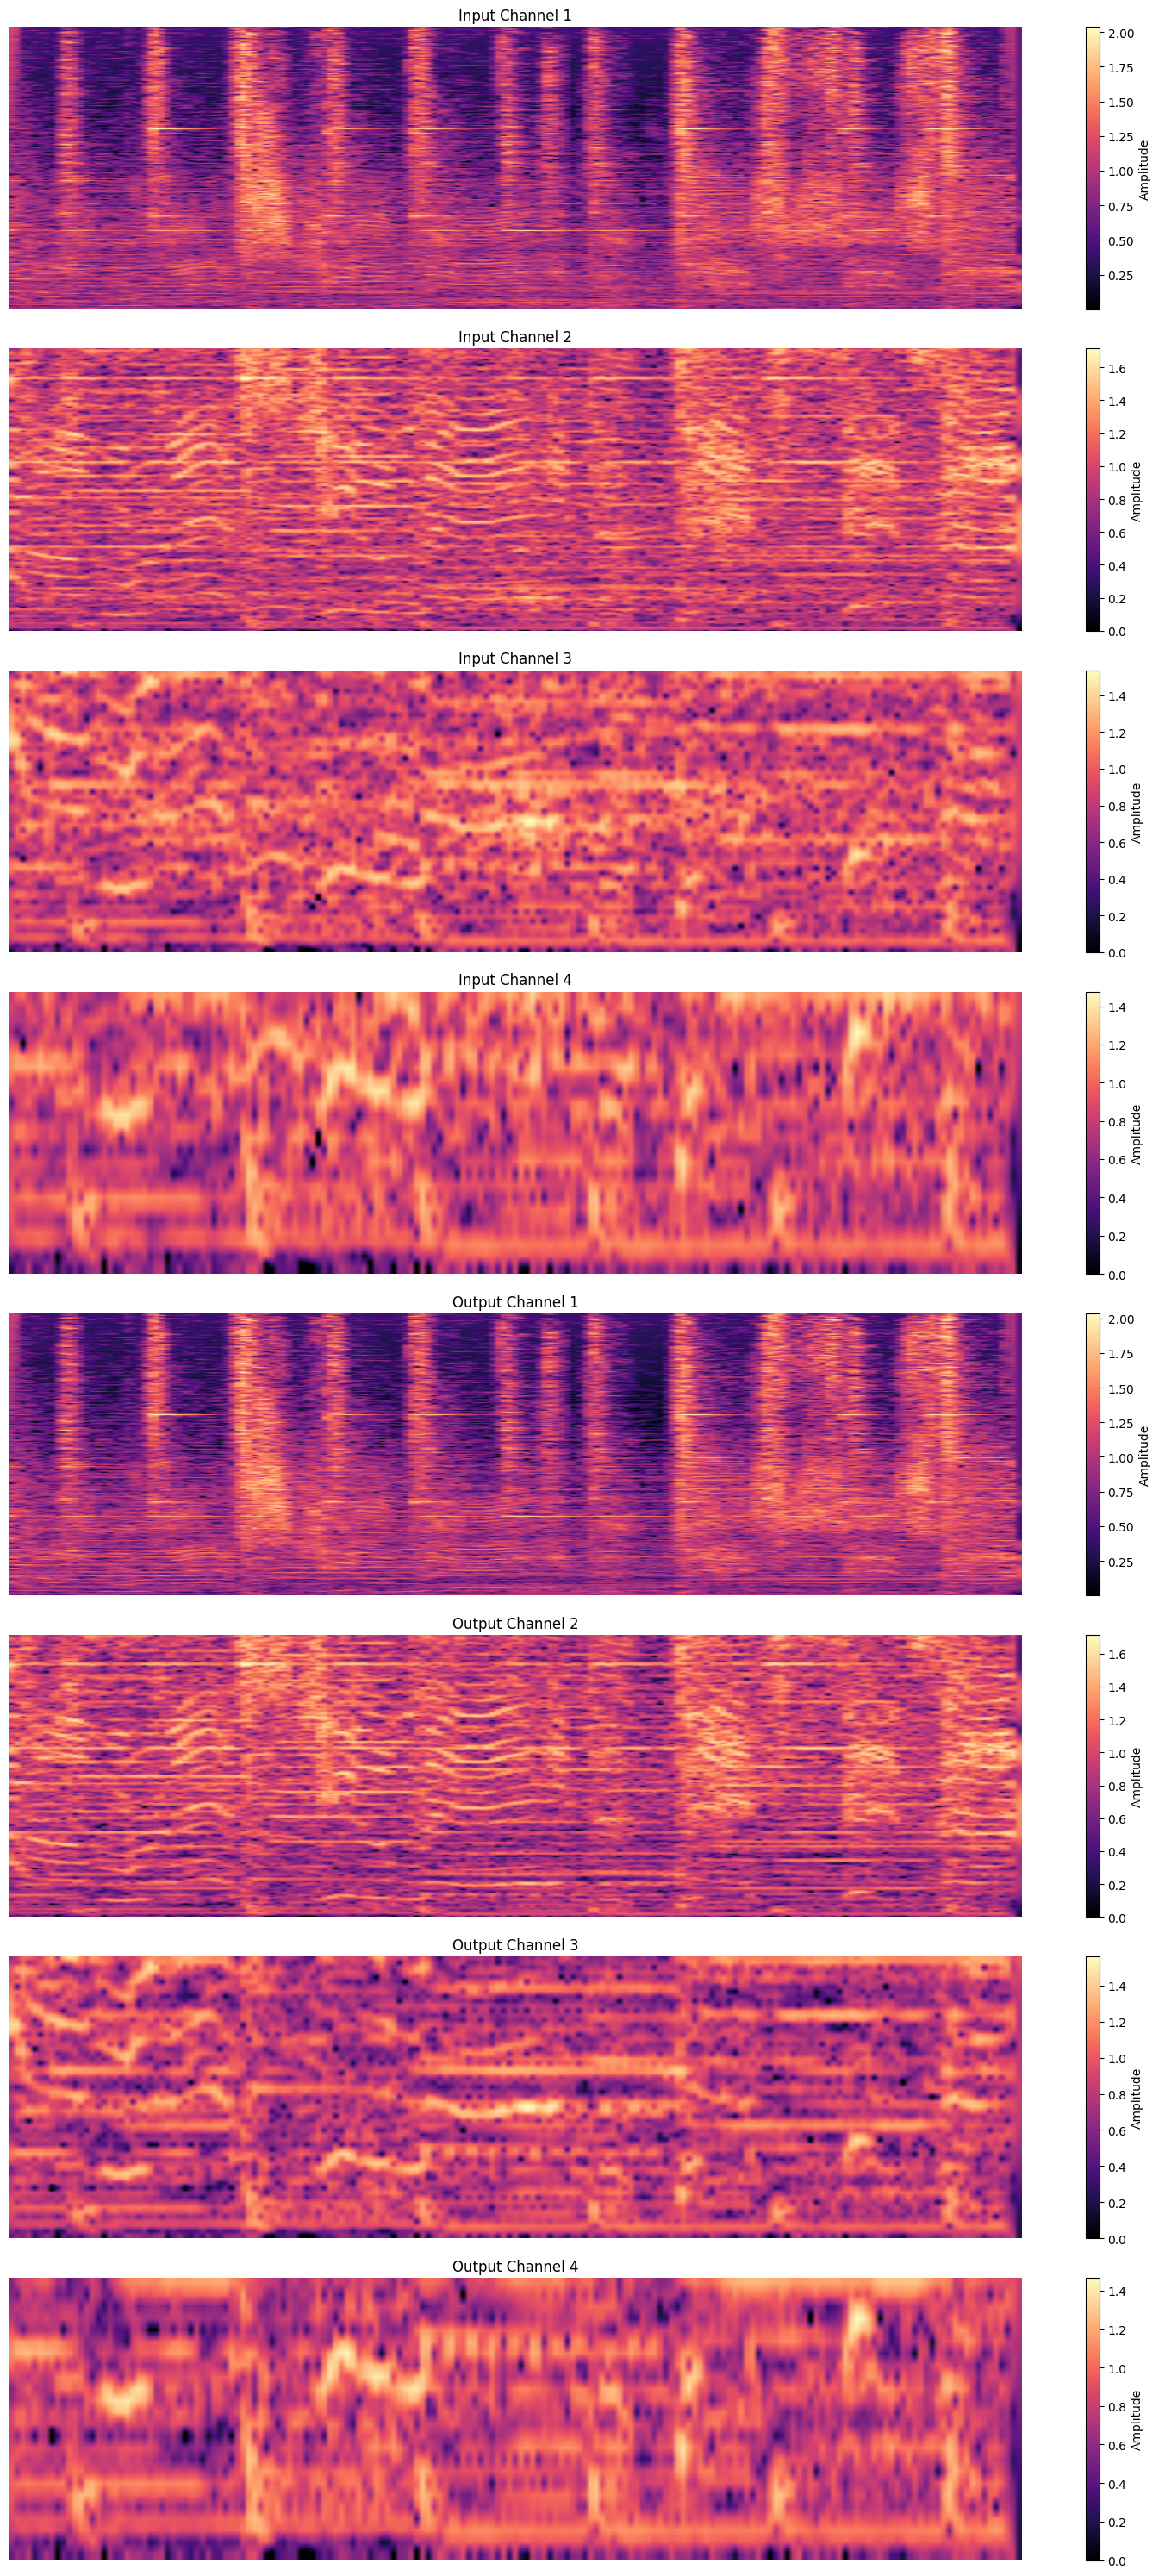

In [16]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample with SNR > 8
  for i in range(100):
      input_tensor, output_tensor, metadata = train_loader.train_dataset[i]
      if metadata['snr_db'] > 8:
          print("Found sample with SNR > 8:")
          print("SNR:", metadata['snr_db'])
          print("Index:", i)
          break  # exit loop after finding the first match



  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [17]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [18]:
import torch

torch.cuda.empty_cache()

In [19]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [20]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [21]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [22]:
from audioautoencoder.training import *

# plot example inputs



Loading model from: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_checkpoint.pth
Checkpoint keys: dict_keys(['model_state_dict', 'entire_model', 'optimizer_state_dict', 'epoch', 'loss', 'total_epochs'])
Loss: 0.15072016417980194, Epoch: 14, Total epochs: 100
Training on device: cuda
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Epoch 15, Current Learning Rate: [3.4227024433899e-06]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.14
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [07:46<00:00,  8.03batch/s, loss=joint loss: 0.1654]


--------------------------------------------------
Epoch 15, Validation Loss: 0.1654
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


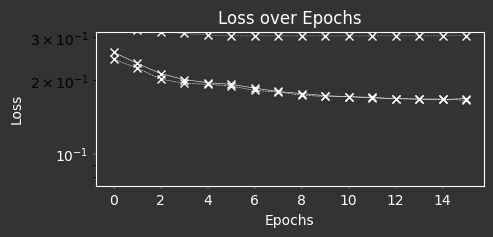

Epoch [15/100], Loss: 0.1681
--------------------------------------------------
Epoch 16, Current Learning Rate: [0.0001]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.15
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [07:47<00:00,  8.01batch/s, loss=joint loss: 0.1647]


--------------------------------------------------
Epoch 16, Validation Loss: 0.1647
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


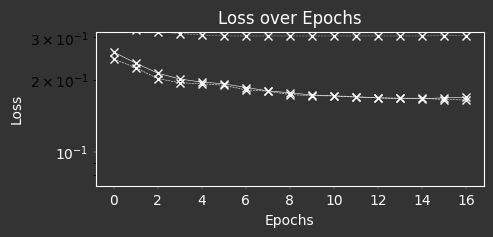

Epoch [16/100], Loss: 0.1688
--------------------------------------------------
Epoch 17, Current Learning Rate: [9.939057285945933e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.16
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [07:58<00:00,  7.81batch/s, loss=joint loss: 0.1624]


--------------------------------------------------
Epoch 17, Validation Loss: 0.1624
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


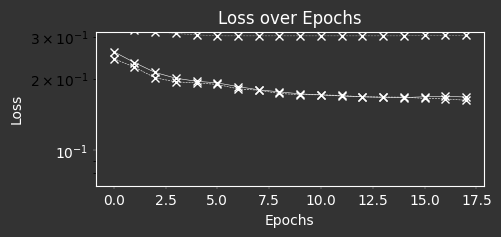

Epoch [17/100], Loss: 0.1677
--------------------------------------------------
Epoch 18, Current Learning Rate: [9.757729755661011e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.17
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [07:56<00:00,  7.85batch/s, loss=joint loss: 0.1610]


--------------------------------------------------
Epoch 18, Validation Loss: 0.1610
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


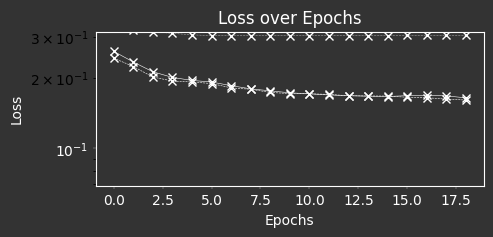

Epoch [18/100], Loss: 0.1644
--------------------------------------------------
Epoch 19, Current Learning Rate: [9.460482294732421e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.18
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [08:15<00:00,  7.55batch/s, loss=joint loss: 0.1601]


--------------------------------------------------
Epoch 19, Validation Loss: 0.1601
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


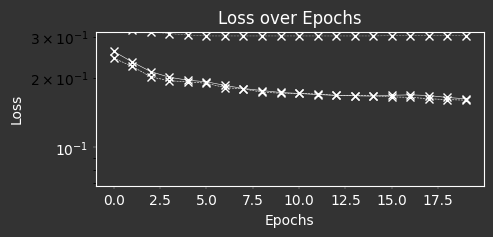

Epoch [19/100], Loss: 0.1622
--------------------------------------------------
Epoch 20, Current Learning Rate: [9.05463412215599e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.19
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [08:16<00:00,  7.53batch/s, loss=joint loss: 0.1607]


--------------------------------------------------
Epoch 20, Validation Loss: 0.1607
EarlyStopping counter: 1 out of 100
Saved to Drive...


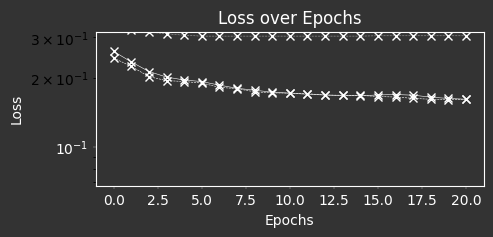

Epoch [20/100], Loss: 0.1610
--------------------------------------------------
Epoch 21, Current Learning Rate: [8.55017856687341e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.2
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [08:19<00:00,  7.49batch/s, loss=joint loss: 0.1597]


--------------------------------------------------
Epoch 21, Validation Loss: 0.1597
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


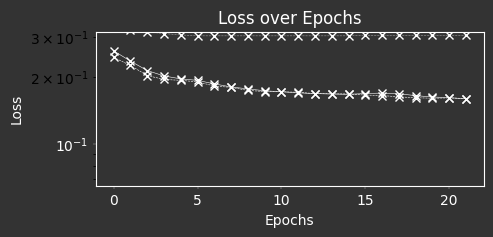

Epoch [21/100], Loss: 0.1592
--------------------------------------------------
Epoch 22, Current Learning Rate: [7.959536998847742e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.21
Noise Level:  0.0


Validating: 100%|██████████| 3741/3741 [08:17<00:00,  7.52batch/s, loss=joint loss: 0.1563]


--------------------------------------------------
Epoch 22, Validation Loss: 0.1563
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetRes12_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


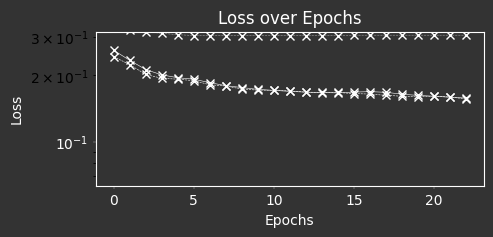

Epoch [22/100], Loss: 0.1580
--------------------------------------------------
Epoch 23, Current Learning Rate: [7.297252973710757e-05]


Training:   0%|          | 0/14964 [00:00<?, ?batch/s]

New kl loss beta: 0.22
Noise Level:  0.0


Training:  57%|█████▋    | 8473/14964 [34:50<26:42,  4.05batch/s, loss=loss: 0.1577, ref:0.3049]

In [ ]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.1, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

___